# Initial data for ICON idealized simulation: temperature, qv, zonal wind on pressure coord

Modified from the script by Nicole Knopf

In [2]:
# load packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# output path
#opath = '/work/bb1152/Module_A/A6_CyclEx/b382037_TingChen/Task3/icon_postprocessing_scripts/paper_figurescript/'
opath = './'

# read data
ipath = '/work/bb1152/Module_A/A6_CyclEx/input_data/'

ds_ctl = xr.open_dataset(ipath + 'lc1_CTL_r720x360.nc').sel(lat=slice(0,90)).squeeze()
ds_4k = xr.open_dataset(ipath + 'lc1_4K_r720x360.nc').sel(lat=slice(0,90)).squeeze()
ds_4k_qvctl = xr.open_dataset(ipath + 'lc1_4K_qvCTL_r720x360.nc').sel(lat=slice(0,90)).squeeze()
ds_tanom = xr.open_dataset(ipath + 'lc1_Tanom_r720x360.nc').sel(lat=slice(0,90)).squeeze()
ds_tanom_tr = xr.open_dataset(ipath + 'lc1_Tanom_tropics_r720x360.nc').sel(lat=slice(0,90)).squeeze()
ds_tanom_po = xr.open_dataset(ipath + 'lc1_Tanom_polar_r720x360.nc').sel(lat=slice(0,90)).squeeze()

del ipath

In [3]:
from metpy.calc import relative_humidity_from_specific_humidity
from metpy.units import units

In [4]:
g        = 9.81               # gravitational acceleration
R        = 287.04             # gas constant

def get_theta(t, p, nlevs, nlats):
    '''
    # function that calculates the potential temperature for given Temperature(t in Kelvin) and pressure,
    '''
    theta = np.full((nlevs, nlats),np.nan,dtype=np.float64)
    
    for le in range(nlevs):
        for la in range(nlats):
            theta[le,la] = t[le,la] * ( 1.e5 / p[le]) ** 0.286
    return theta

def get_T_v(t, shu):
    '''
    # function that calculates the virtual temperature for given Temperature(t in Kelvin),
    # Relative Humidity(rh [0-100]) & Pressure(p in hPa)
    # we calculate the specific humidity
    '''
    T_v = t * (1 + 0.608 * shu)
    return T_v



def get_N(theta, t, p, nlevs, nlats):
    '''
    # function that calculates the Brunt–Väisälä frequency
    # https://glossary.ametsoc.org/wiki/Brunt-v%C3%A4is%C3%A4l%C3%A4_frequency
    # we use pressure coordinate:
    # https://snowball.millersville.edu/~adecaria/ESCI342/ANSWERS/esci342_exercises_answers_lesson12.html
    # N**2 = - P / (R * T_v) * g**2 / theta_v * (d theta_v) / (d p) 
    '''
    N = np.full((nlevs, nlats),np.nan,dtype=np.float64)
    
    for le in range(nlevs):
        leU = min (le+1, nlevs-1)
        leL = max (le-1, 0)
        N[le,:] = (- p[le] / R / t[le,:] * g**2 / theta[le,:] * (theta[leU,:]-theta[leL,:]) / (p[leU]-p[leL]) )#**0.5
     
    return N


In [5]:
temp_ctl = ds_ctl['T'].mean('lon')
temp_4k = ds_4k['T'].mean('lon')
temp_4k_qvctl = ds_4k_qvctl['T'].mean('lon')
temp_tanom = ds_tanom['T'].mean('lon')
temp_tanom_tr = ds_tanom_tr['T'].mean('lon')
temp_tanom_po = ds_tanom_po['T'].mean('lon')


diff= temp_tanom-temp_ctl
diff_lat = diff.mean('lat')
#print(diff_lat)
#diff_mean = diff_lat.mean('lev')
#print(diff_mean)
#temp_tanom_lat = temp_tanom.mean('lat')

In [6]:
qv_ctl = ds_ctl['QV'].mean('lon')*1.e3
qv_4k = ds_4k['QV'].mean('lon')*1.e3
qv_4k_qvctl = ds_4k_qvctl['QV'].mean('lon')*1.e3
qv_tanom = ds_tanom['QV'].mean('lon')*1.e3
qv_tanom_tr = ds_tanom_tr['QV'].mean('lon')*1.e3
qv_tanom_po = ds_tanom_po['QV'].mean('lon')*1.e3

In [7]:
u_ctl = ds_ctl['U'].mean('lon')
u_4k = ds_4k['U'].mean('lon')
u_4k_qvctl = ds_4k_qvctl['U'].mean('lon')
u_tanom = ds_tanom['U'].mean('lon')
u_tanom_tr = ds_tanom_tr['U'].mean('lon')
u_tanom_po = ds_tanom_po['U'].mean('lon')

In [8]:
def load_levelinfo():
    from netCDF4 import Dataset
    ipath = '/work/bb1152/Module_A/A6_CyclEx/input_data/'
    file = Dataset(ipath + 'ifs2icon_verticalgridinfo_137levels.nc', 'r')
    hyam = np.squeeze(np.array(file.variables['hyam']))
    hybm = np.squeeze(np.array(file.variables['hybm']))   
    return hyam, hybm
    
hyam, hybm = load_levelinfo()
    
# constants
# physical constants are set to the values used in icon-nwp-2.0.15/src/shared/mo_physical_constants.f90
H      = 7.5e3          # in m
p0     = 1.0e5          # globally-uniform surface pressure in Pa



# vertical grid: for computation of initial state we convert the ifs2icon hybrid levels
# to height levels assuming a globally-uniform surface pressure (defined above)
# and defining ehight according to Polvani and Elsner as z = H ln (p0/p)
p  = hyam + hybm*p0
z  = H*np.log(p0/p)  # np.log is natural logarithm
nz   = z.size

print(ds_ctl['T'].shape)
print(temp_ctl.shape)
#print(len(z),z)
#print(np.shape(temp_ctl))
#indizes = []
#for i in range(0,len(z)):
#    if z[i]/1e3 > 40:
#        indizes.append(i)
#z = np.delete(z, indizes)
#temp_ctl[0] = np.delete(temp_ctl[0],indizes)
#print(len(z),z)

#print(z, nz)

diff_latm = np.ma.masked_where(p<20000, diff_lat)
#print(diff_latm)
diff_mean150hPa = diff_latm.mean()
#print(diff_mean150hPa)
#temp_tanom_lat = temp_tanom.mean('lat')

(137, 180, 720)
(137, 180)


In [9]:
print(p.shape)
print(temp_ctl.shape)

(137,)
(137, 180)


In [10]:
p2d= np.zeros_like(temp_ctl)

for i in range(temp_ctl.shape[1]):
    p2d[:,i]=p[:]/100.
    
print(p2d)

[[1.0001825e-02 1.0001825e-02 1.0001825e-02 ... 1.0001825e-02
  1.0001825e-02 1.0001825e-02]
 [2.5513031e-02 2.5513031e-02 2.5513031e-02 ... 2.5513031e-02
  2.5513031e-02 2.5513031e-02]
 [3.8841624e-02 3.8841624e-02 3.8841624e-02 ... 3.8841624e-02
  3.8841624e-02 3.8841624e-02]
 ...
 [9.9362622e+02 9.9362622e+02 9.9362622e+02 ... 9.9362622e+02
  9.9362622e+02 9.9362622e+02]
 [9.9633508e+02 9.9633508e+02 9.9633508e+02 ... 9.9633508e+02
  9.9633508e+02 9.9633508e+02]
 [9.9881506e+02 9.9881506e+02 9.9881506e+02 ... 9.9881506e+02
  9.9881506e+02 9.9881506e+02]]


In [11]:
rh_ctl = relative_humidity_from_specific_humidity(p2d * units.hPa,
                                         temp_ctl * units.degK, qv_ctl*1.e-3)
rh_4k  = relative_humidity_from_specific_humidity(p2d * units.hPa,
                                         temp_4k * units.degK, qv_4k*1.e-3)
rh_4k_qvctl= relative_humidity_from_specific_humidity(p2d * units.hPa,
                                         temp_4k_qvctl * units.degK, qv_4k_qvctl*1.e-3)
print(rh_ctl)

<xarray.DataArray (lev: 137, lat: 180)>
<Quantity([[-0.         -0.         -0.         ... -0.         -0.
  -0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.7928538   0.7928538   0.7928538  ...  0.79044384  0.79044384
   0.79044384]
 [ 0.7942843   0.7942843   0.7942843  ...  0.7919446   0.7919446
   0.7919446 ]
 [ 0.79559153  0.79559153  0.79559153 ...  0.79331696  0.79331696
   0.79331696]], 'dimensionless')>
Coordinates:
    time     float64 2.379e+07
  * lat      (lat) float64 0.25 0.75 1.25 1.75 2.25 ... 88.25 88.75 89.25 89.75
  * lev      (lev) float64 1.0 2.0 3.0 4.0 5.0 ... 133.0 134.0 135.0 136.0 137.0
    lev_2    float64 1.0


In [12]:

print(temp_ctl.shape)
print(ds_ctl['lat'].shape)
print(temp_ctl[-1,0])
print(temp_ctl[-1,-1])
print(ds_ctl['lat'][89])

print((temp_ctl[-1,89]+temp_ctl[-1,90])*0.5)

(137, 180)
(180,)
<xarray.DataArray 'T' ()>
array(299.9422, dtype=float32)
Coordinates:
    time     float64 2.379e+07
    lat      float64 0.25
    lev      float64 137.0
    lev_2    float64 1.0
<xarray.DataArray 'T' ()>
array(255.68442, dtype=float32)
Coordinates:
    time     float64 2.379e+07
    lat      float64 89.75
    lev      float64 137.0
    lev_2    float64 1.0
<xarray.DataArray 'lat' ()>
array(44.75)
Coordinates:
    time     float64 2.379e+07
    lat      float64 44.75
    lev_2    float64 1.0
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y
<xarray.DataArray 'T' ()>
array(277.60131836)
Coordinates:
    time     float64 2.379e+07
    lev      float64 137.0
    lev_2    float64 1.0


In [13]:
print(ds_ctl['lat'][89])

<xarray.DataArray 'lat' ()>
array(44.75)
Coordinates:
    time     float64 2.379e+07
    lat      float64 44.75
    lev_2    float64 1.0
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y


In [14]:
print(u_ctl.max())

print(u_ctl[72,90])
print(p[114]/100)

<xarray.DataArray 'U' ()>
array(44.99350357)
Coordinates:
    time     float64 2.379e+07
    lev_2    float64 1.0
<xarray.DataArray 'U' ()>
array(44.912903, dtype=float32)
Coordinates:
    time     float64 2.379e+07
    lat      float64 45.25
    lev      float64 73.0
    lev_2    float64 1.0
852.9173020076752


<xarray.DataArray ()>
<Quantity(-0.2255392074584961, 'dimensionless')>
Coordinates:
    time     float64 2.379e+07
    lev_2    float64 1.0
<xarray.DataArray (lev: 0, lat: 180)>
<Quantity([], 'dimensionless')>
Coordinates:
    time     float64 2.379e+07
  * lat      (lat) float64 0.25 0.75 1.25 1.75 2.25 ... 88.25 88.75 89.25 89.75
  * lev      (lev) float64 
    lev_2    float64 1.0


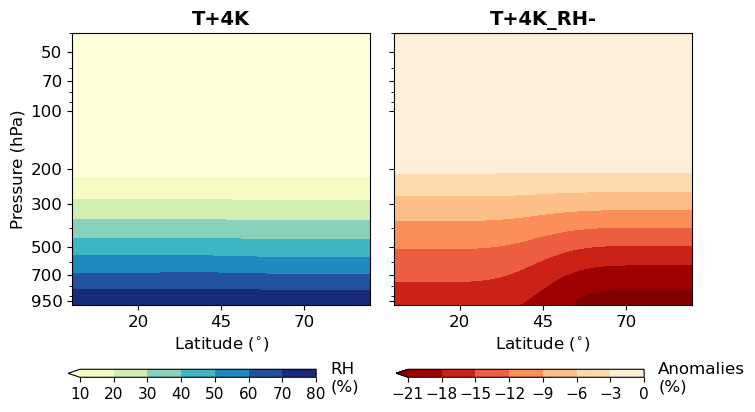

In [26]:
# plot zonal-mean temp as lat-height cross section
import matplotlib.ticker

fig, ax = plt.subplots(1,2, figsize=(8,4), sharex=False, sharey=True)
clevels = np.arange(0.25,9.,0.5)
#clevels = [0.25,1,2,3,4,5,6,7,8,9]
tclevels = np.arange(230,305,5)
qvclevels = np.arange(0.5,5,1)
#qvclevelsctl = np.arange(0.5,18,4)
qvclevelsctl = [0.5,5,10,15]
clevels_cbar= np.linspace(-6, 6, 13)

cqv="royalblue"

#-----------------for temperature & qv fields--------------------

# plot ctl

ax_ctl  = ax[0].contourf(ds_ctl['lat'], p/100., rh_4k*100,  cmap=plt.cm.get_cmap('YlGnBu'), extend="min")

#cbaxes = fig.add_axes([0.49, 0.13, 0.014, 0.6])


#ax[0,0].axvline(45, linestyle = "--", color = "dimgray", linewidth=0.5)
ax[0].set_xlabel('Latitude ($^{\circ}$)', fontsize=12)
ax[0].set_ylabel('Pressure (hPa)', fontsize=12)
ax[0].tick_params(axis='both', which='major', labelsize=12)

#
plt.gca().invert_yaxis()
plt.yscale('log')
ax[0].set_ylim(1000,40)
plt.yticks([950,700,500,300,200,100,70,50], [950,700,500,300,200,100,70,50])
ax[0].set_xticks([20,45,70])
ax[0].set_xticklabels([20,45,70])

#clb = plt.colorbar(ax_ctl)

#divider = make_axes_locatable(ax[0,0])
#cax_s = divider.append_axes('bottom', size='4%', pad=0.6)
#cbar = fig.colorbar(ax_ctl,cax=cax_s,orientation='horizontal',shrink=0.95, ticks=tclevels[0:-1])
#cbar.set_label(label='(K)')
#cbar.formatter.set_scientific(False)
#cbar.formatter.set_powerlimits((0, 0))

#cbaxes = fig.add_axes([0.48, 0.13, 0.014, 0.5])
cbaxes = fig.add_axes([0.12, 0.02, 0.31, 0.02])
clb = plt.colorbar(ax_ctl,
                         shrink=0.5,
                         orientation='horizontal',
                         cax = cbaxes,
                         extend='max')
        
clb.ax.set_title('RH\n(%)',  ha='left',x=1.06, y=-1.8, fontsize=12, transform=clb.ax.transAxes)
clb.ax.tick_params(labelsize=11)

#-------------------------------------------------------------

ax_4k_qvctl  = ax[1].contourf(ds_ctl['lat'], p/100., (rh_4k_qvctl-rh_4k)*100,  cmap=plt.cm.get_cmap('OrRd_r'), extend="min")

print ((rh_4k_qvctl-rh_4k).min())
#rint (rh_4k_qvctl[1,1])

print ((rh_4k_qvctl[114:89]-rh_4k[114:89]))
#ax[0,0].axvline(45, linestyle = "--", color = "dimgray", linewidth=0.5)
ax[1].set_xlabel('Latitude ($^{\circ}$)', fontsize=12)
#ax[1].set_ylabel('Pressure (hPa)', fontsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)

#
plt.gca().invert_yaxis()
plt.yscale('log')
ax[1].set_ylim(1000,40)

ax[1].set_xticks([20,45,70])
ax[1].set_xticklabels([20,45,70])

#plt.yticks([950,700,500,300,200,100,70,50], [950,700,500,300,200,100,70,50])

#divider = make_axes_locatable(ax[0,0])
#cax_s = divider.append_axes('bottom', size='4%', pad=0.6)
#cbar = fig.colorbar(ax_ctl,cax=cax_s,orientation='horizontal',shrink=0.95, ticks=tclevels[0:-1])
#cbar.set_label(label='(K)')
#cbar.formatter.set_scientific(False)
#cbar.formatter.set_powerlimits((0, 0))

#clb.ax.set_title('(K)',x=1.06, y=0, ha='left',
#                             fontsize=12, transform=clb.ax.transAxes)
#clb.ax.tick_params(labelsize=11)

cbaxes = fig.add_axes([0.53, 0.02, 0.31, 0.02])
clb = plt.colorbar(ax_4k_qvctl,
                         shrink=0.5,
                         orientation='horizontal',
                         cax = cbaxes,
                         extend='max')
        

clb.ax.set_title('Anomalies\n(%)', ha='left', x=1.06, y=-1.8, fontsize=12, transform=clb.ax.transAxes)
clb.ax.tick_params(labelsize=11)
ax[0].set_yticks([950,700,500,300,200,100,70,50])
ax[0].set_yticklabels([950,700,500,300,200,100,70,50])
ax[1].set_yticks([950,700,500,300,200,100,70,50])
ax[1].set_yticklabels([950,700,500,300,200,100,70,50])
ax[0].set_title('T+4K', fontsize=14, weight='bold',y=1.0)
ax[1].set_title('T+4K_RH-', fontsize=14, weight='bold',y=1.0)

plt.subplots_adjust(wspace = 0.08, bottom=0.2)
fig.savefig('Fig_Reviewer1_inidata_RH_twoexp.png', bbox_inches='tight', dpi=150)
plt.show(fig)
plt.close(fig)
del fig, ax

/tmp/ipykernel_155345/619632333.py:21: UserWarning: No contour levels were found within the data range.
  ax_ctl2 = ax[0,0].contour(ds_ctl['lat'], p/100., qv_ctl, levels = [0], colors="blue")


u_tanom.max= <xarray.DataArray 'U' ()>
array(44.99350357)
Coordinates:
    time     float64 2.379e+07
    lev_2    float64 1.0


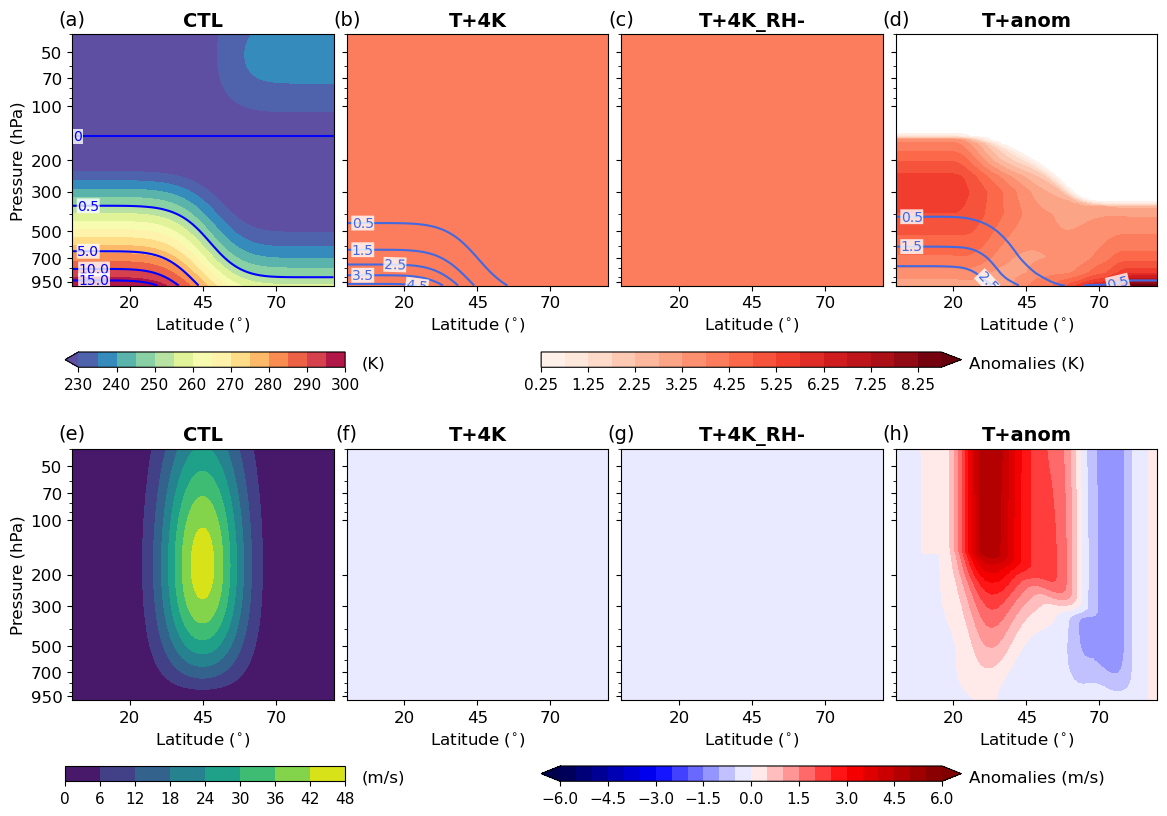

In [16]:
# plot zonal-mean temp as lat-height cross section
import matplotlib.ticker

fig, ax = plt.subplots(2, 4, figsize=(14,9), sharex=False, sharey=True)
clevels = np.arange(0.25,9.,0.5)
#clevels = [0.25,1,2,3,4,5,6,7,8,9]
tclevels = np.arange(230,305,5)
qvclevels = np.arange(0.5,5,1)
#qvclevelsctl = np.arange(0.5,18,4)
qvclevelsctl = [0.5,5,10,15]
clevels_cbar= np.linspace(-6, 6, 13)

cqv="royalblue"

#-----------------for temperature & qv fields--------------------

# plot ctl

ax_ctl  = ax[0,0].contourf(ds_ctl['lat'], p/100., temp_ctl, levels = tclevels, cmap=plt.cm.get_cmap('Spectral_r'), extend="min")

ax_ctl2 = ax[0,0].contour(ds_ctl['lat'], p/100., qv_ctl, levels = [0], colors="blue")
clabels = plt.clabel(ax_ctl2, inline=False,fontsize=10)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.8, pad=0.3)) for txt in clabels]
ax_ctl2 = ax[0,0].contour(ds_ctl['lat'], p/100., qv_ctl, levels = qvclevelsctl, colors="blue")
#clabels = plt.clabel(ax_ctl2, inline=False,fmt='%.0e', fontsize=10)
clabels = plt.clabel(ax_ctl2, inline=False,fontsize=10)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.8, pad=0.3)) for txt in clabels]

#ax[0,0].axvline(45, linestyle = "--", color = "dimgray", linewidth=0.5)
ax[0,0].set_xlabel('Latitude ($^{\circ}$)', fontsize=12)
ax[0,0].set_ylabel('Pressure (hPa)', fontsize=12)
ax[0,0].tick_params(axis='both', which='major', labelsize=12)

#
plt.gca().invert_yaxis()
plt.yscale('log')
ax[0,0].set_ylim(1000,40)
plt.yticks([950,700,500,300,200,100,70,50], [950,700,500,300,200,100,70,50])
ax[0,0].set_xticks([20,45,70])
ax[0,0].set_xticklabels([20,45,70])

#divider = make_axes_locatable(ax[0,0])
#cax_s = divider.append_axes('bottom', size='4%', pad=0.6)
#cbar = fig.colorbar(ax_ctl,cax=cax_s,orientation='horizontal',shrink=0.95, ticks=tclevels[0:-1])
#cbar.set_label(label='(K)')
#cbar.formatter.set_scientific(False)
#cbar.formatter.set_powerlimits((0, 0))
cbaxes = fig.add_axes([0.12, 0.51, 0.2, 0.017])
        
clb = plt.colorbar(ax_ctl,
                         shrink=0.5,
                         orientation='horizontal',
                         cax = cbaxes,
                         extend='max')
        
clb.ax.set_title('(K)',x=1.06, y=0, ha='left',
                             fontsize=12, transform=clb.ax.transAxes)
clb.ax.tick_params(labelsize=11)

# plot 4k
ax_4k = ax[0,1].contourf(ds_ctl['lat'], p/100., temp_4k-temp_ctl, levels = clevels, extend='max', cmap=plt.cm.get_cmap('Reds'))
ax_4k2 = ax[0,1].contour(ds_ctl['lat'], p/100., (qv_4k-qv_ctl), levels = qvclevels,colors=cqv)
clabels = plt.clabel(ax_4k2, inline=False, fontsize=10)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.8, pad=0.3)) for txt in clabels]

#ax[0,1].axvline(45, linestyle = "--", color = "dimgray", linewidth=0.5)

ax[0,1].set_xlabel('Latitude ($^{\circ}$)', fontsize=12)
ax[0,1].tick_params(axis='both', which='major', labelsize=12)
ax[0,1].set_xticks([20,45,70])
ax[0,1].set_xticklabels([20,45,70])
#ax[0,1].set_ylabel('Pressure (hPa)', fontsize=12)

#divider = make_axes_locatable(ax[0,1])
#cax_s = divider.append_axes('bottom', size='4%', pad=0.6)
#cbar = fig.colorbar(ax_4k,cax=cax_s,orientation='horizontal',shrink=0.95)
#cbar.set_label(label='(K)')
#cbar.formatter.set_scientific(False)
#cbar.formatter.set_powerlimits((0, 0))

# plot 4k_qvctl
ax_4k_qvctl = ax[0,2].contourf(ds_ctl['lat'], p/100., temp_4k_qvctl-temp_ctl, levels = clevels, extend='max', cmap=plt.cm.get_cmap('Reds'))
#ax_4k_qvctl2 = ax[0,2].contour(ds_ctl['lat'], p/100., qv_4k_qvctl-qv_ctl, levels = qvclevels,colors=cqv)
#ax[0,2].axvline(45, linestyle = "--", color = "dimgray", linewidth=0.5)

ax[0,2].set_xlabel('Latitude ($^{\circ}$)', fontsize=12)
ax[0,2].tick_params(axis='both', which='major', labelsize=12)
ax[0,2].set_xticks([20,45,70])
ax[0,2].set_xticklabels([20,45,70])
#ax[0,2].set_ylabel('Pressure (hPa)', fontsize=12)

#divider = make_axes_locatable(ax[0,2])
#cax_s = divider.append_axes('bottom', size='4%', pad=0.6)
#cbar = fig.colorbar(ax_4k_qvctl,cax=cax_s,orientation='horizontal',shrink=0.95)
#cbar.set_label(label='(K)')
#cbar.formatter.set_scientific(False)
#cbar.formatter.set_powerlimits((0, 0))

cbaxes = fig.add_axes([0.46, 0.51, 0.3, 0.017])
        
clb = plt.colorbar(ax_4k_qvctl,
                         shrink=0.5,
                         orientation='horizontal',
                         cax = cbaxes,
                         extend='max')
        
clb.ax.set_title('Anomalies (K)',x=1.07, y=0, ha='left',
                             fontsize=12, transform=clb.ax.transAxes)
clb.ax.tick_params(labelsize=11)


# plot tanom
ax_tanom = ax[0,3].contourf(ds_ctl['lat'], p/100., temp_tanom-temp_ctl, levels = clevels, extend='max', cmap=plt.cm.get_cmap('Reds'))

ax_tanom2 = ax[0,3].contour(ds_ctl['lat'], p/100., (qv_tanom-qv_ctl), levels = qvclevels,colors=cqv)
clabels = plt.clabel(ax_tanom2, inline=False, fontsize=10)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.8, pad=0.3)) for txt in clabels]

#ax[0,3].axvline(45, linestyle = "--", color = "dimgray", linewidth=0.5)

ax[0,3].set_xlabel('Latitude ($^{\circ}$)', fontsize=12)
ax[0,3].tick_params(axis='both', which='major', labelsize=12)
ax[0,3].set_xticks([20,45,70])
ax[0,3].set_xticklabels([20,45,70])
#ax[0,3].set_ylabel('Pressure (hPa)', fontsize=12)

#divider = make_axes_locatable(ax[0,3])
#cax_s = divider.append_axes('bottom', size='4%', pad=0.6)
#cbar = fig.colorbar(ax_tanom,cax=cax_s,orientation='horizontal',shrink=0.95)
#cbar.set_label(label='(K)')
#cbar.formatter.set_scientific(False)
#cbar.formatter.set_powerlimits((0, 0))


ax[0,0].set_title('CTL', fontsize=14, weight='bold',y=1.0)
ax[0,1].set_title('T+4K', fontsize=14, weight='bold',y=1.0)
ax[0,2].set_title('T+4K_RH-', fontsize=14, weight='bold',y=1.0)
ax[0,3].set_title('T+anom', fontsize=14, weight='bold',y=1.0)

plt.text(0, 1.1, '(a)', ha='center', va='top', transform=ax[0,0].transAxes, fontsize=14) 
plt.text(0, 1.1, '(b)', ha='center', va='top', transform=ax[0,1].transAxes, fontsize=14) 
plt.text(0, 1.1, '(c)', ha='center', va='top', transform=ax[0,2].transAxes, fontsize=14) 
plt.text(0, 1.1, '(d)', ha='center', va='top', transform=ax[0,3].transAxes, fontsize=14) 
#-----------------for zonal wind field--------------------
clevels = np.arange(-6,6.5,0.5)

# plot ctl
ax_ctl = ax[1,0].contourf(ds_ctl['lat'], p/100., u_ctl)

#ax[1,0].axvline(45, linestyle = "--", color = "dimgray", linewidth=0.5)
ax[1,0].set_xlabel('Latitude ($^{\circ}$)', fontsize=12)
ax[1,0].set_ylabel('Pressure (hPa)', fontsize=12)
ax[1,0].tick_params(axis='both', which='major', labelsize=12)

plt.gca().invert_yaxis()
plt.yscale('log')
ax[1,0].set_ylim(1000,40)
plt.yticks([950,700,500,300,200,100,70,50], [950,700,500,300,200,100,70,50])
ax[1,0].set_xticks([20,45,70])
ax[1,0].set_xticklabels([20,45,70])

#divider = make_axes_locatable(ax[1,0])
#cax_s = divider.append_axes('bottom', size='4%', pad=0.6)
#cbar = fig.colorbar(ax_ctl,cax=cax_s,orientation='horizontal',shrink=0.95)
#cbar.set_label(label='(m/s)')
#cbar.formatter.set_scientific(False)
#cbar.formatter.set_powerlimits((0, 0))

cbaxes = fig.add_axes([0.12, 0.05, 0.2, 0.017])
        
clb = plt.colorbar(ax_ctl,
                         shrink=0.5,
                         orientation='horizontal',
                         cax = cbaxes,
                         extend='max')
        
clb.ax.set_title('(m/s)',x=1.06, y=0, ha='left',
                             fontsize=12, transform=clb.ax.transAxes)
clb.ax.tick_params(labelsize=11)

# plot 4k
ax_4k = ax[1,1].contourf(ds_ctl['lat'], p/100., u_4k-u_ctl, levels = clevels, extend='both', cmap=plt.cm.get_cmap('seismic'))
#ax[1,1].axvline(45, linestyle = "--", color = "dimgray", linewidth=0.5)
ax[1,1].set_xticks([20,45,70])
ax[1,1].set_xticklabels([20,45,70])
ax[1,1].set_xlabel('Latitude ($^{\circ}$)', fontsize=12)
ax[1,1].tick_params(axis='both', which='major', labelsize=12)

#ax[1,1].set_ylabel('Pressure (hPa)', fontsize=12)

#divider = make_axes_locatable(ax[1,1])
#cax_s = divider.append_axes('bottom', size='4%', pad=0.6)
#cbar = fig.colorbar(ax_4k,cax=cax_s,orientation='horizontal',shrink=0.95)

#cbar.set_label(label='(m/s)')
#cbar.set_ticks(clevels_cbar)
#cbar.formatter.set_scientific(False)
#cbar.formatter.set_powerlimits((0, 0))

# plot 4k_qvctl
ax_4k_qvctl = ax[1,2].contourf(ds_ctl['lat'], p/100., u_4k_qvctl-u_ctl, levels = clevels, extend='both', cmap=plt.cm.get_cmap('seismic'))
#ax[1,2].axvline(45, linestyle = "--", color = "dimgray", linewidth=0.5)
ax[1,2].set_xticks([20,45,70])
ax[1,2].set_xticklabels([20,45,70])

ax[1,2].set_xlabel('Latitude ($^{\circ}$)', fontsize=12)
ax[1,2].tick_params(axis='both', which='major', labelsize=12)

#ax[1,2].set_ylabel('Pressure (hPa)', fontsize=12)

#divider = make_axes_locatable(ax[1,2])
#cax_s = divider.append_axes('bottom', size='4%', pad=0.6)
#cbar = fig.colorbar(ax_4k_qvctl,cax=cax_s,orientation='horizontal',shrink=0.95)

#cbar.set_label(label='(m/s)')
#cbar.set_ticks(clevels_cbar)
#cbar.formatter.set_scientific(False)
#cbar.formatter.set_powerlimits((0, 0))

cbaxes = fig.add_axes([0.46, 0.05, 0.3, 0.017])
        
clb = plt.colorbar(ax_4k_qvctl,
                         shrink=0.5,
                         orientation='horizontal',
                         cax = cbaxes,
                         extend='max')
        
clb.ax.set_title('Anomalies (m/s)',x=1.07, y=0, ha='left',
                             fontsize=12, transform=clb.ax.transAxes)
clb.ax.tick_params(labelsize=11)

# plot tanom
ax_tanom = ax[1,3].contourf(ds_ctl['lat'], p/100., u_tanom-u_ctl, levels = clevels, extend='both', cmap=plt.cm.get_cmap('seismic'))
#ax_tanom = ax[1,3].contourf(ds_ctl['lat'], p/100., u_tanom)

print('u_tanom.max=', np.max(u_ctl))
ax[1,3].set_xticks([20,45,70])
ax[1,3].set_xticklabels([20,45,70])
#ax[1,3].axvline(45, linestyle = "--", color = "dimgray", linewidth=0.5)

ax[1,3].set_xlabel('Latitude ($^{\circ}$)', fontsize=12)
ax[1,3].tick_params(axis='both', which='major', labelsize=12)


plt.text(0, 1.1, '(e)', ha='center', va='top', transform=ax[1,0].transAxes, fontsize=14) 
plt.text(0, 1.1, '(f)', ha='center', va='top', transform=ax[1,1].transAxes, fontsize=14) 
plt.text(0, 1.1, '(g)', ha='center', va='top', transform=ax[1,2].transAxes, fontsize=14) 
plt.text(0, 1.1, '(h)', ha='center', va='top', transform=ax[1,3].transAxes, fontsize=14) 

ax[1,0].set_title('CTL', fontsize=14, weight='bold',y=1.0)
ax[1,1].set_title('T+4K', fontsize=14, weight='bold',y=1.0)
ax[1,2].set_title('T+4K_RH-', fontsize=14, weight='bold',y=1.0)
ax[1,3].set_title('T+anom', fontsize=14, weight='bold',y=1.0)

#ax[1,3].set_ylabel('Pressure (hPa)', fontsize=12)

#divider = make_axes_locatable(ax[1,3])
#cax_s = divider.append_axes('bottom', size='4%', pad=0.6)
#cbar = fig.colorbar(ax_tanom,cax=cax_s,orientation='horizontal',shrink=0.95)

#cbar.set_label(label='(m/s)')
#cbar.set_ticks(clevels_cbar)
#cbar.formatter.set_scientific(False)
#cbar.formatter.set_powerlimits((0, 0))


plt.subplots_adjust(wspace = 0.05, hspace = 0.65, bottom=0.14)

fig.savefig(opath + 'FigR1_inidata_T_qv_overview_EXP1-4.png', bbox_inches='tight')
plt.show(fig)
plt.close(fig)
del fig, ax

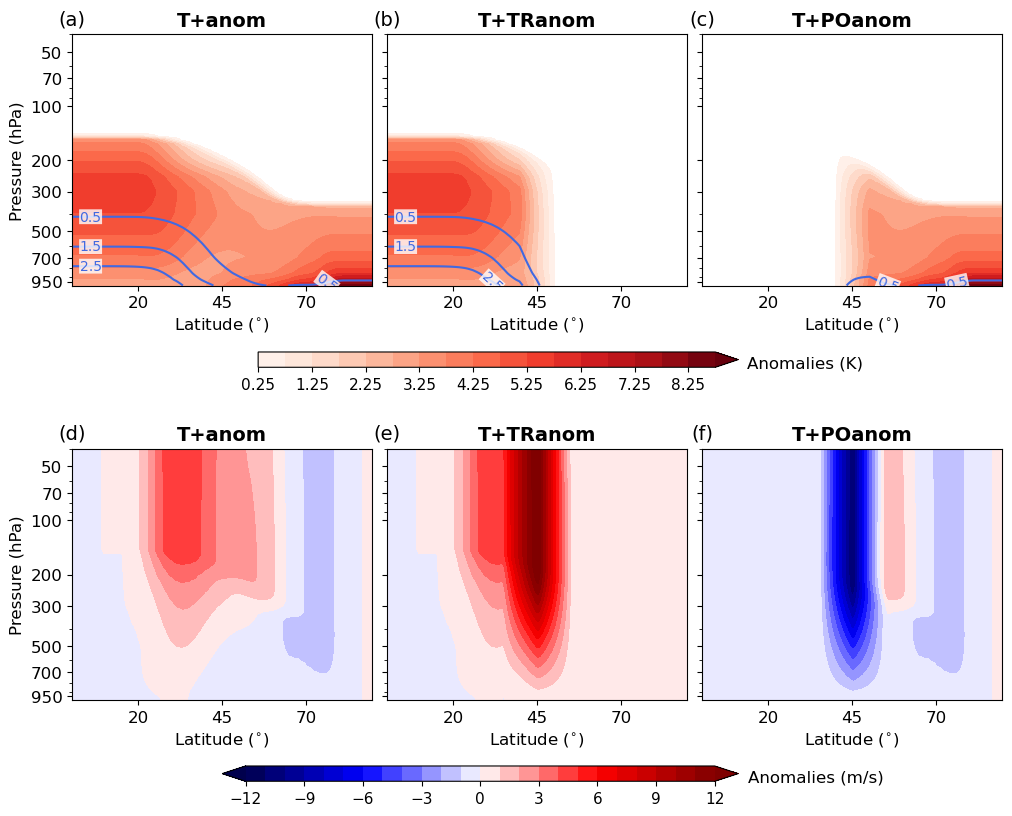

In [9]:
# plot zonal-mean temp as lat-height cross section
import matplotlib.ticker

fig, ax = plt.subplots(2, 3, figsize=(12,9), sharex=False, sharey=True)
clevels = np.arange(0.25,9.,0.5)
#clevels = [0.25,1,2,3,4,5,6,7,8,9]
tclevels = np.arange(215,310,10)
#qvclevels = np.arange(5e-5,5e-3,1e-3)
qvclevelsctl = np.arange(0.,3e-2,0.5e-2)
clevels_cbar= np.linspace(-6, 6, 13)

cqv="royalblue"

#-----------------for temperature & qv fields--------------------

# plot tanom

ax_tanom  = ax[0,0].contourf(ds_ctl['lat'], p/100., temp_tanom-temp_ctl, levels = clevels, cmap=plt.cm.get_cmap('Reds'))
ax_tanom2 = ax[0,0].contour(ds_ctl['lat'], p/100., qv_tanom-qv_ctl, levels = qvclevels, colors=cqv)
clabels = plt.clabel(ax_tanom2, inline=False, fontsize=10)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.8, pad=0.3)) for txt in clabels]

#ax[0,0].axvline(45, linestyle = "--", color = "dimgray", linewidth=0.5)
ax[0,0].set_xlabel('Latitude ($^{\circ}$)', fontsize=12)
ax[0,0].set_ylabel('Pressure (hPa)', fontsize=12)
ax[0,0].tick_params(axis='both', which='major', labelsize=12)

#
plt.gca().invert_yaxis()
plt.yscale('log')
ax[0,0].set_ylim(1000,40)
plt.yticks([950,700,500,300,200,100,70,50], [950,700,500,300,200,100,70,50])
ax[0,0].set_xticks([20,45,70])
ax[0,0].set_xticklabels([20,45,70])

#divider = make_axes_locatable(ax[0,0])
#cax_s = divider.append_axes('bottom', size='4%', pad=0.6)
#cbar = fig.colorbar(ax_ctl,cax=cax_s,orientation='horizontal',shrink=0.95, ticks=tclevels[0:-1])
#cbar.set_label(label='(K)')
#cbar.formatter.set_scientific(False)
#cbar.formatter.set_powerlimits((0, 0))


# plot TR tanom
ax_tr = ax[0,1].contourf(ds_ctl['lat'], p/100., temp_tanom_tr-temp_ctl, levels = clevels, extend='max', cmap=plt.cm.get_cmap('Reds'))
ax_tr2 = ax[0,1].contour(ds_ctl['lat'], p/100., qv_tanom_tr-qv_ctl, levels = qvclevels,colors=cqv)
clabels = plt.clabel(ax_tr2, inline=False, fontsize=10)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.8, pad=0.3)) for txt in clabels]

#ax[0,1].axvline(45, linestyle = "--", color = "dimgray", linewidth=0.5)

ax[0,1].set_xlabel('Latitude ($^{\circ}$)', fontsize=12)
ax[0,1].tick_params(axis='both', which='major', labelsize=12)
ax[0,1].set_xticks([20,45,70])
ax[0,1].set_xticklabels([20,45,70])
#ax[0,1].set_ylabel('Pressure (hPa)', fontsize=12)

#divider = make_axes_locatable(ax[0,1])
#cax_s = divider.append_axes('bottom', size='4%', pad=0.6)
#cbar = fig.colorbar(ax_4k,cax=cax_s,orientation='horizontal',shrink=0.95)
#cbar.set_label(label='(K)')
#cbar.formatter.set_scientific(False)
#cbar.formatter.set_powerlimits((0, 0))

# plot PO tanom
ax_po = ax[0,2].contourf(ds_ctl['lat'], p/100., temp_tanom_po-temp_ctl, levels = clevels, extend='max', cmap=plt.cm.get_cmap('Reds'))
ax_po2 = ax[0,2].contour(ds_ctl['lat'], p/100., qv_tanom_po-qv_ctl, levels = qvclevels,colors=cqv)
clabels = plt.clabel(ax_po2, inline=False, fontsize=10)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.8, pad=0.3)) for txt in clabels]



ax[0,2].set_xlabel('Latitude ($^{\circ}$)', fontsize=12)
ax[0,2].tick_params(axis='both', which='major', labelsize=12)
ax[0,2].set_xticks([20,45,70])
ax[0,2].set_xticklabels([20,45,70])
#ax[0,2].set_ylabel('Pressure (hPa)', fontsize=12)

#divider = make_axes_locatable(ax[0,2])
#cax_s = divider.append_axes('bottom', size='4%', pad=0.6)
#cbar = fig.colorbar(ax_4k_qvctl,cax=cax_s,orientation='horizontal',shrink=0.95)
#cbar.set_label(label='(K)')
#cbar.formatter.set_scientific(False)
#cbar.formatter.set_powerlimits((0, 0))

cbaxes = fig.add_axes([0.28, 0.51, 0.4, 0.017])
        
clb = plt.colorbar(ax_po,
                         shrink=0.5,
                         orientation='horizontal',
                         cax = cbaxes,
                         extend='max')
        
clb.ax.set_title('Anomalies (K)',x=1.07, y=0, ha='left',
                             fontsize=12, transform=clb.ax.transAxes)
clb.ax.tick_params(labelsize=11)



ax[0,0].set_title('T+anom', fontsize=14, weight='bold',y=1.0)
ax[0,1].set_title('T+TRanom', fontsize=14, weight='bold',y=1.0)
ax[0,2].set_title('T+POanom', fontsize=14, weight='bold',y=1.0)


plt.text(0, 1.1, '(a)', ha='center', va='top', transform=ax[0,0].transAxes, fontsize=14) 
plt.text(0, 1.1, '(b)', ha='center', va='top', transform=ax[0,1].transAxes, fontsize=14) 
plt.text(0, 1.1, '(c)', ha='center', va='top', transform=ax[0,2].transAxes, fontsize=14) 

#-----------------for zonal wind field--------------------
clevels = np.arange(-12,13,1)

# plot tanom
ax_tanom = ax[1,0].contourf(ds_ctl['lat'], p/100., u_tanom-u_ctl, levels = clevels, extend='both', cmap=plt.cm.get_cmap('seismic'))
ax[1,0].set_xticks([20,45,70])
ax[1,0].set_xticklabels([20,45,70])
#ax[1,3].axvline(45, linestyle = "--", color = "dimgray", linewidth=0.5)

ax[1,0].set_xlabel('Latitude ($^{\circ}$)', fontsize=12)
ax[1,0].set_ylabel('Pressure (hPa)', fontsize=12)
ax[1,0].tick_params(axis='both', which='major', labelsize=12)

plt.gca().invert_yaxis()
plt.yscale('log')
ax[1,0].set_ylim(1000,40)
plt.yticks([950,700,500,300,200,100,70,50], [950,700,500,300,200,100,70,50])
ax[1,0].set_xticks([20,45,70])
ax[1,0].set_xticklabels([20,45,70])


# plot TR tanom
ax_tanom_tr= ax[1,1].contourf(ds_ctl['lat'], p/100., u_tanom_tr-u_ctl, levels = clevels, extend='both', cmap=plt.cm.get_cmap('seismic'))
#ax[1,2].axvline(45, linestyle = "--", color = "dimgray", linewidth=0.5)
ax[1,1].set_xticks([20,45,70])
ax[1,1].set_xticklabels([20,45,70])

ax[1,1].set_xlabel('Latitude ($^{\circ}$)', fontsize=12)
ax[1,1].tick_params(axis='both', which='major', labelsize=12)

#ax[1,2].set_ylabel('Pressure (hPa)', fontsize=12)

#divider = make_axes_locatable(ax[1,2])
#cax_s = divider.append_axes('bottom', size='4%', pad=0.6)
#cbar = fig.colorbar(ax_4k_qvctl,cax=cax_s,orientation='horizontal',shrink=0.95)

#cbar.set_label(label='(m/s)')
#cbar.set_ticks(clevels_cbar)
#cbar.formatter.set_scientific(False)
#cbar.formatter.set_powerlimits((0, 0))

# plot PO tanom
ax_tanom_po= ax[1,2].contourf(ds_ctl['lat'], p/100., u_tanom_po-u_ctl, levels = clevels, extend='both', cmap=plt.cm.get_cmap('seismic'))
#ax[1,2].axvline(45, linestyle = "--", color = "dimgray", linewidth=0.5)
ax[1,2].set_xticks([20,45,70])
ax[1,2].set_xticklabels([20,45,70])

ax[1,2].set_xlabel('Latitude ($^{\circ}$)', fontsize=12)
ax[1,2].tick_params(axis='both', which='major', labelsize=12)

cbaxes = fig.add_axes([0.25, 0.05, 0.43, 0.017])
        
clb = plt.colorbar(ax_tanom_po,
                         shrink=0.5,
                         orientation='horizontal',
                         cax = cbaxes,
                         extend='max')
        
clb.ax.set_title('Anomalies (m/s)',x=1.07, y=0, ha='left',
                             fontsize=12, transform=clb.ax.transAxes)
clb.ax.tick_params(labelsize=11)

plt.text(0, 1.1, '(d)', ha='center', va='top', transform=ax[1,0].transAxes, fontsize=14) 
plt.text(0, 1.1, '(e)', ha='center', va='top', transform=ax[1,1].transAxes, fontsize=14) 
plt.text(0, 1.1, '(f)', ha='center', va='top', transform=ax[1,2].transAxes, fontsize=14) 
ax[1,0].set_title('T+anom', fontsize=14, weight='bold',y=1.0)
ax[1,1].set_title('T+TRanom', fontsize=14, weight='bold',y=1.0)
ax[1,2].set_title('T+POanom', fontsize=14, weight='bold',y=1.0)

plt.subplots_adjust(wspace = 0.05, hspace = 0.65, bottom=0.14)

fig.savefig(opath + 'FigA1_inidata_T_qv_overview_EXP4-6.png', bbox_inches='tight')
plt.show(fig)
plt.close(fig)
del fig, ax